# The Sims-Flanagan high-fidelity trajectory leg

The Sims-Flanagan trajectory leg {cite:p}`sims` is implemented in `pykep` in the class {class}`pykep.leg.sims_flanagan_hf`. The leg can be used to describe efficiently a low-thrust leg with low-fidelity as it assumes Keplerian dynamics
and approximates the continuous thrust via a sequence of continuous, constant thrust arcs. The leg is defined by a starting position $\mathbf x_s = [\mathbf r_s, \mathbf v_s, m_s]$, an arrival position $\mathbf x_f = [\mathbf r_f, \mathbf v_f, m_f]$ and a time of flight $T$.

A sequence of throttles $\mathbf u = [u_{x0}, u_{y0}, u_{z0}, u_{x1}, u_{y1}, u_{z1}, u_{x2}, u_{y2}, u_{z2}, ... ]$ define the direction and magnitude of the continuous thrust vector along each segment (i.e. trajectory parts of equal temporal length $\frac Tn$).

In this tutorial we show the basic API to interface with the class {class}`pykep.leg.sims_flanagan_hf` efficiently.

We start with some imports:

In [1]:
import pykep as pk
import numpy as np
import time

from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d

%matplotlib inline

We then define the spacecraft propulsion system and the initial and final state. In this case they are not related to any orbital mechanics and are chosen arbitrarily for the purpose of clearlyshowing the API.

In [2]:
# Problem data
mu = pk.MU_SUN
max_thrust = 0.12
isp = 3000

# Initial state
ms = 1500.0
rs = np.array([1, 0.1, -0.1]) * pk.AU
vs = np.array([0.2, 1, -0.2]) * pk.EARTH_VELOCITY

# Final state
mf = 1300.0
rf = np.array([-1.2, -0.1, 0.1]) * pk.AU
vf = np.array([0.2, -1.023, 0.44]) * pk.EARTH_VELOCITY

# Throttles and tof
nseg = 10
cut = 0.6
throttles = np.random.uniform(-1, 1, size=(nseg * 3))
tof = 324.0 * pk.DAY2SEC
# We are now ready to instantiate a leg
sf = pk.leg.sims_flanagan_hf(
    rvs=[rs, vs],
    ms=ms,
    throttles=throttles,
    rvf=[rf, vf],
    mf=mf,
    tof=tof,
    max_thrust=max_thrust,
    isp=isp,
    mu=mu,
    cut=cut,
)

Now we instantiate the leg:

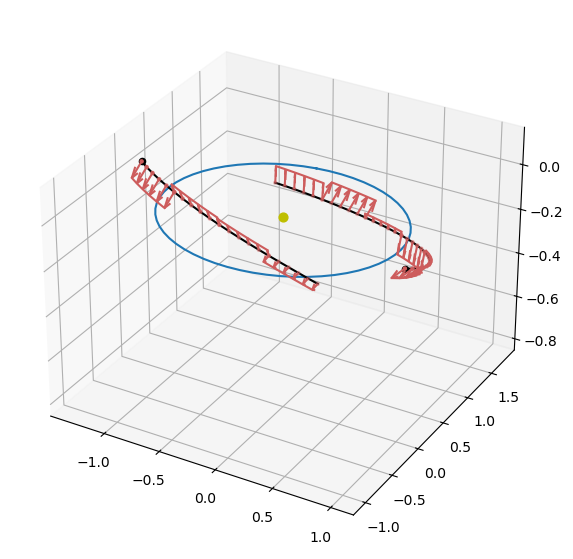

In [4]:
# Making the axis
ax = pk.plot.make_3Daxis(figsize=(7, 7))

# Adding the Sun Earth and the boundary states
udpla = pk.udpla.jpl_lp(body="EARTH")
earth = pk.planet(udpla)
pk.plot.add_sun(ax, s=40)
pk.plot.add_planet_orbit(ax, earth)
ax.scatter(rs[0] / pk.AU, rs[1] / pk.AU, rs[2] / pk.AU, c="k", s=20)
ax.scatter(rf[0] / pk.AU, rf[1] / pk.AU, rf[2] / pk.AU, c="k", s=20)


# Plotting the trajctory leg
ax = pk.plot.add_sf_hf_leg(
    ax, sf, units=pk.AU, N=5, show_gridpoints=True, show_throttles=True, length=0.1, arrow_length_ratio=0.5
)
